<a href="https://colab.research.google.com/github/tongrabbit/covidSentiment/blob/main/ML-covid19%20tweet%20sentiment%20analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import pandas as pd
import json
from tqdm import tqdm_notebook

os.chdir('/content/drive/MyDrive/Colab Notebooks')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import re 
import nltk 
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, KFold


from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('ggplot')
import matplotlib.patches as mpatches

In [ ]:
train=pd.read_csv("Corona_NLP_train.csv",encoding='latin1')
test=pd.read_csv("Corona_NLP_test.csv",encoding='latin1')

In [ ]:
train['text'] = train.OriginalTweet
train["text"] = train["text"].astype(str)

test['text'] = test.OriginalTweet
test["text"] = test["text"].astype(str)

# Data has 5 classes, let's convert them to 3
## 감정구분을 3가지로
def classes_def(x):
    if x ==  "Extremely Positive":
        return "2"
    elif x == "Extremely Negative":
        return "0"
    elif x == "Negative":
        return "0"
    elif x ==  "Positive":
        return "2"
    else:
        return "1"
    
## Sentiment 컬럼 데이터를 class_def에 적용하여 바꿈
train['label']=train['Sentiment'].apply(lambda x:classes_def(x))
test['label']=test['Sentiment'].apply(lambda x:classes_def(x))

## 어떤 컬럼/Series의 unique value들을 count해주는 함수
## normalize=True : 비율 확인
train.label.value_counts(normalize= True)

2    0.438467
0    0.374128
1    0.187404
Name: label, dtype: float64

In [ ]:
## 정규표현식 이용하여 전처리
# Remove Urls and HTML links
def remove_urls(text):
    url_remove = re.compile(r'https?://\S+|www\.\S+') 
    return url_remove.sub(r'', text)
train['text_new']=train['text'].apply(lambda x:remove_urls(x))
test['text_new']=test['text'].apply(lambda x:remove_urls(x))

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)
train['text']=train['text_new'].apply(lambda x:remove_html(x))
test['text']=test['text_new'].apply(lambda x:remove_html(x))

In [ ]:
# Lower casing
def lower(text):
    low_text= text.lower()
    return low_text
train['text_new']=train['text'].apply(lambda x:lower(x))
test['text_new']=test['text'].apply(lambda x:lower(x))


# Number removal
def remove_num(text):
    remove= re.sub(r'\d+', '', text) 
    return remove
train['text']=train['text_new'].apply(lambda x:remove_num(x))
test['text']=test['text_new'].apply(lambda x:remove_num(x))

In [ ]:
#Remove stopwords & Punctuations
import nltk
nltk.download('stopwords')

#Remove stopwords & Punctuations
from nltk.corpus import stopwords
", ".join(stopwords.words('english'))
STOPWORDS = set(stopwords.words('english'))

def punct_remove(text):
    punct = re.sub(r"[^\w\s\d]","", text) 
    return punct

train['text_new']=train['text'].apply(lambda x:punct_remove(x))
test['text_new']=test['text'].apply(lambda x:punct_remove(x))

def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
train['text']=train['text_new'].apply(lambda x:remove_stopwords(x))
test['text']=test['text_new'].apply(lambda x:remove_stopwords(x))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
#Remove mentions and hashtags
def remove_mention(x):
    text=re.sub(r'@\w+','',x)
    return text
train['text_new']=train['text'].apply(lambda x:remove_mention(x))
test['text_new']=test['text'].apply(lambda x:remove_mention(x))

def remove_hash(x):
    text=re.sub(r'#\w+','',x)
    return text
train['text']=train['text_new'].apply(lambda x:remove_hash(x))
test['text']=test['text_new'].apply(lambda x:remove_hash(x))

#Remove extra white space left while removing stuff
def remove_space(text):
    space_remove = re.sub(r"\s+"," ",text).strip()
    return space_remove
train['text_new']=train['text'].apply(lambda x:remove_space(x))
test['text_new']=test['text'].apply(lambda x:remove_space(x))
test = test.drop(columns=['text_new'])
train = train.drop(columns=['text_new'])

In [ ]:
stop_words = ['a', 'an', 'the']

# Basic cleansing
def cleansing(text):
    # Tokenize
    tokens = text.split(' ')
    # Lower case
    tokens = [w.lower() for w in tokens]
    # Remove stop words
    tokens = [w for w in tokens if w not in stop_words]
    return ' '.join(tokens)

# All-in-one preproce
def preprocess_x(x):
    processed_x = [cleansing(text) for text in x]
    
    return processed_x
    
train['text_new']=train['text'].apply(lambda x:preprocess_x(x))
test['text_new']=test['text'].apply(lambda x:preprocess_x(x))

In [ ]:
X = train["text"].tolist()
y = train["label"].tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.10,
                                                    random_state = 0)

In [ ]:
## sublinear_tf : 높은 tf값을 완만하게 처리
## min_df : DF의 최소값을 설정하여 해당 값보다 작은 DF를 가진 단어들 제외 

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        stop_words='english')

# We transform each text into a vector
features = tfidf.fit_transform(train.text).toarray()

labels = train.label

print("Each of the %d tweets is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

Each of the 41157 tweets is represented by 10615 features (TF-IDF score of unigrams and bigrams)


In [ ]:
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(),
    MultinomialNB(),
]

# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

In [ ]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
model_name,,
LinearSVC,0.784411,0.004532
MultinomialNB,0.659791,0.003452
RandomForestClassifier,0.470029,0.003683


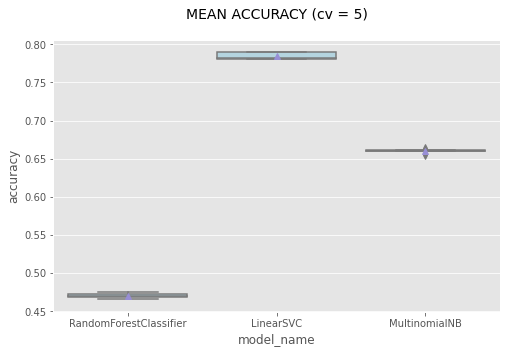

In [ ]:
plt.figure(figsize=(8,5))
sns.boxplot(x='model_name', y='accuracy', 
            data=cv_df, 
            color='lightblue', 
            showmeans=True)
plt.title("MEAN ACCURACY (cv = 5)\n", size=14);

In [ ]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features, 
                                                               labels, 
                                                               train.index, test_size=0.10, 
                                                               random_state=1)
model =   LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [ ]:
# Classification report

from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(y_test, y_pred, 
                                    target_names= train['label'].unique()))

				CLASSIFICATIION METRICS

              precision    recall  f1-score   support

           1       0.80      0.79      0.80      1554
           2       0.69      0.67      0.68       760
           0       0.82      0.84      0.83      1802

    accuracy                           0.79      4116
   macro avg       0.77      0.77      0.77      4116
weighted avg       0.79      0.79      0.79      4116



NameError: ignored

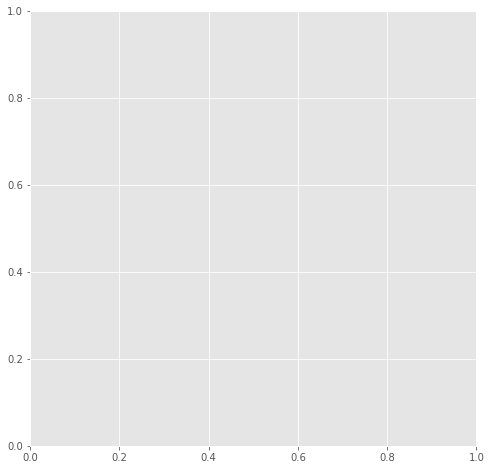

In [ ]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=sentiment_id_df.label.values, 
            yticklabels=sentiment_id_df.label.values)
train = train.drop(columns=['sentiment'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVC\n", size=16);